In [1]:
import cartopy.crs as ccrs

import iris,glob
import numpy as np
import matplotlib.pyplot as plt
import iris.plot as iplt
from iris.util import equalise_attributes

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import interp1d
import iris.coord_categorisation as icc
import pandas as pd
import xarray as xr
import intake
import seaborn as sns
import datetime
from iris.coords import DimCoord
from iris.cube import Cube
import os

def iris_regrid(cube,res=2.,lat=60):
    
    lat_points = np.arange(-1*lat,lat+1,res)
    lon_points = np.arange(0,360,res)

    latitude = DimCoord(lat_points,
                        standard_name='latitude',
                        units='degrees')
    longitude = DimCoord(lon_points,
                         standard_name='longitude',
                         units='degrees')
    new_cube = Cube(np.zeros((len(lat_points), len(lon_points)), np.float32),
                dim_coords_and_dims=[(latitude, 0),
                                     (longitude, 1)])

    try:
        for i in ['longitude','latitude']:
            cube.coord(i).bounds=None
            cube.coord(i).guess_bounds()
            new_cube.coord(i).guess_bounds()
    except:pass
    
    cube=cube.regrid(new_cube,iris.analysis.AreaWeighted(mdtol=0.5))
    
    return(cube)

# B percentiles CMIP6 (Fig. 1)

In [6]:
B=iris.load_cube('./input/B_era5.nc','b')

In [ ]:
landsea_mask=iris.load_cube('./input/landsea_mask.nc')
for i in ['longitude','latitude']:
    landsea_mask.coord(i).guess_bounds()
    try: B.coord(i).guess_bounds()
    except:pass

landsea_mask = iris_regrid(landsea_mask,lat=30)
landmask = np.where(landsea_mask.data<50,True,False)
B = iris_regrid(B,lat=30)

n = np.shape(B)[0]
Bmask = B.copy(np.ma.masked_where([landmask]*n,B.data))

fulldata = Bmask.data.data[~Bmask.data.mask]
pcs = np.arange(5,100,5)
Bbins = np.percentile(fulldata,pcs)

B = iris.load_cube('./input/B_NCEP.nc')
B = iris_regrid(B,lat=30)
n = np.shape(B)[0]
Bmask_ncep = B.copy(np.ma.masked_where([landmask]*n,B.data))

fulldata = Bmask_ncep.data.data[~Bmask_ncep.data.mask]
pcs = np.arange(5,100,5)
Bbins_ncep = np.percentile(fulldata,pcs)

In [8]:
#define the modelnames of data (e.g.)
#fnames = glob.glob('./output/CRE_adj/SWCREadj_*.nc')
#modelnames = list(map(lambda s: s.split('/')[-1].split('_')[1],fnames))


In [ ]:
#calculating the percentiles for B

Bbins_cmip=[]

for modelname in modelnames:
    B = iris.load_cube(f'./output/B/B_piControl_{modelname}.nc')
        
    B.coord('latitude').standard_name = 'latitude'
    B.coord('longitude').standard_name = 'longitude'
    B.coord('latitude').units = 'degrees'
    B.coord('longitude').units = 'degrees'
    
    for i in ['longitude','latitude']:
        try:
            B.coord(i).guess_bounds()
        except:pass
    
    B = iris_regrid(B,lat=30)
    landmask = np.where(landsea_mask.data<50,True,False)

    B = B.copy(np.ma.masked_where([landmask]*1800,B.data))

    fulldata = B.data.data[~B.data.mask]
    Bbins = np.percentile(fulldata,pcs)
    Bbins_cmip.append(Bbins)
    

In [10]:
#finding institution of data using pangeo (optional)

def retrieve_institution(modelnames):
    col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    query = dict(
        experiment_id='piControl', 
        table_id='Amon',
        variable_id='tas', 
        source_id=modelnames,
    )
    col_subset = col.search(require_all_on=["source_id"], **query)
    col_subset=col_subset.df.loc[col_subset.df['member_id'].str.contains("r1i1p1", case=False)]
    col_subset = col_subset.groupby('source_id').apply(lambda x: x.iloc[0])

    return col_subset['institution_id']

inst = retrieve_institution(modelnames)

inst_names = inst.unique()
inst_cat = inst.apply(lambda x: np.squeeze(np.where(inst_names==x)))
inst_cat.name = 'inst_cat'
ms = np.zeros(np.shape(inst))

for i in np.unique(inst):
    ms[inst==i] = range((inst==i).sum())
ms = pd.Series(ms,name='mod_num',index=inst.index)

inst = pd.concat([inst,inst_cat,ms],axis=1)

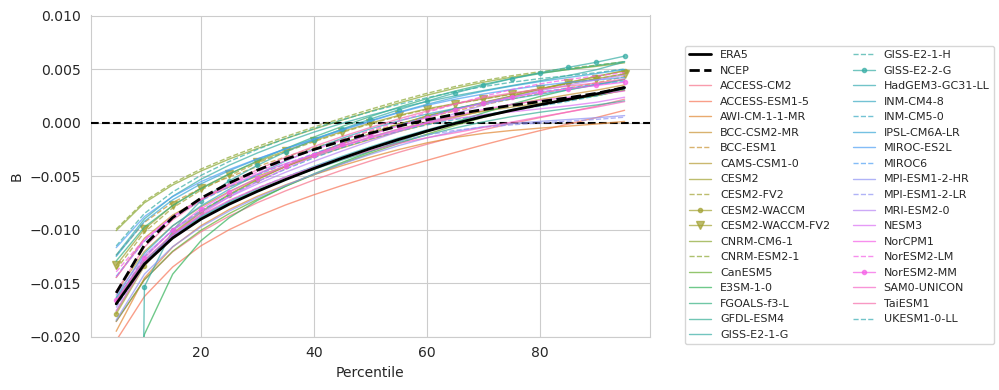

In [12]:
#plotting Fig. 1

cols = sns.color_palette("husl", len(inst_names))

cols2 = np.array(cols)[inst['inst_cat'].values]
styles = np.array(['solid','dashed','solid','solid'])[inst['mod_num'].values.astype(int)]
mstyles = np.array([None,None,'.','v'])[inst['mod_num'].values.astype(int)]

sns.set_style('whitegrid')
x=np.arange(5,100,5)
fig,ax=plt.subplots(figsize=[10,4])
ax.plot(x,Bbins,'k-',zorder=5,linewidth=2,label='ERA5')
ax.plot(x,Bbins_ncep,'k--',zorder=5,linewidth=2,label='NCEP')

ax.plot(x,Bbins_cmip[0],color=cols2[0],linestyle='solid',zorder=4,linewidth=1,label=modelnames[0],alpha=.7)
[ax.plot(x,y,color=c,linestyle=s,zorder=4,linewidth=1,label=m,marker=ma,alpha=.7) 
     for y,c,s,m,ma in zip(Bbins_cmip[1:],cols2[1:],styles[1:],modelnames[1:],mstyles[1:])]

ax.axhline(0,color='k',linestyle='dashed',zorder=3)
ax.set_xlabel('Percentile')
ax.set_ylabel('B')
ax.set_ylim([-0.02,0.01])
fig.legend(loc=7,ncols=2,fontsize=8)
plt.tight_layout(rect=[0, 0, 0.67, 1])
plt.savefig('./paper_figs/Fig1.png',dpi=300)


# B percentiles AMIP Supp. Fig. S2

In [61]:
#list modelnames (e.g.)

#fnames = glob.glob('./output/B/B_*_amip.nc')
#modelnames_amip = list(map(lambda s: s.split('/')[-1].split('_')[1],fnames))
modelnames_amip

array(['BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'E3SM-1-0',
       'GFDL-CM4', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6',
       'MRI-ESM2-0', 'NorESM2-LM'], dtype='<U15')

In [ ]:
#calculate percentiles of B

Bbins_amip=[]

for modelname in modelnames_amip:
    print(modelname)
    B = iris.load_cube('./output/B/B_amip_{0}.nc'.format(modelname))
    
    B.coord('latitude').standard_name = 'latitude'
    B.coord('longitude').standard_name = 'longitude'
    B.coord('latitude').units = 'degrees'
    B.coord('longitude').units = 'degrees'
    B = iris_regrid(B,lat=30)

    landmask = np.where(landsea_mask.data<50,True,False)

    B = B.copy(np.ma.masked_where([landmask]*np.shape(B)[0],B.data))

    fulldata = B.data.data[~B.data.mask]
    Bbins2 = np.percentile(fulldata,pcs)
    Bbins_amip.append(Bbins2)
    


In [65]:
#retrieve institution (optional)

inst = retrieve_institution(modelnames_amip)

inst_names = inst.unique()
inst_cat = inst.apply(lambda x: np.squeeze(np.where(inst_names==x)))
inst_cat.name = 'inst_cat'
ms = np.zeros(np.shape(inst))
#ms = np.concatenate([range((inst==i).sum()) for i in np.unique(inst)])
for i in np.unique(inst):
    ms[inst==i] = range((inst==i).sum())
ms = pd.Series(ms,name='mod_num',index=inst.index)

inst = pd.concat([inst,inst_cat,ms],axis=1)

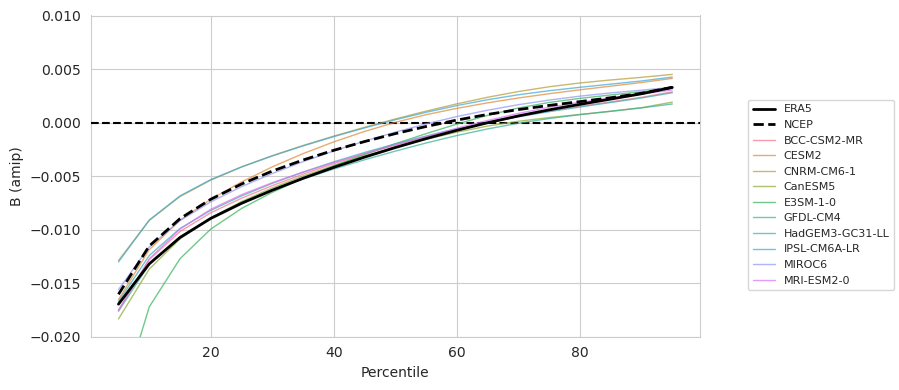

In [66]:
cols = sns.color_palette("husl", len(inst_names))

cols2 = np.array(cols)[inst['inst_cat'].values]
styles = np.array(['solid','dashed','solid','solid'])[inst['mod_num'].values.astype(int)]
mstyles = np.array([None,None,'.','v'])[inst['mod_num'].values.astype(int)]

sns.set_style('whitegrid')
x=np.arange(5,100,5)
fig,ax=plt.subplots(figsize=[9,4])
ax.plot(x,Bbins,'k-',zorder=5,linewidth=2,label='ERA5')
ax.plot(x,Bbins_ncep,'k--',zorder=5,linewidth=2,label='NCEP')

ax.plot(x,Bbins_amip[0],color=cols2[0],linestyle='solid',zorder=4,linewidth=1,label=modelnames_amip[0],alpha=.7)
[ax.plot(x,y,color=c,linestyle=s,zorder=4,linewidth=1,label=m,marker=ma,alpha=.7) 
     for y,c,s,m,ma in zip(Bbins_amip[1:],cols2[1:],styles[1:],modelnames_amip[1:],mstyles[1:])]

ax.axhline(0,color='k',linestyle='dashed',zorder=3)
ax.set_xlabel('Percentile')
ax.set_ylabel('B (amip)')
ax.set_ylim([-0.02,0.01])
fig.legend(loc=7,fontsize=8)
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.savefig('./paper_figs/supp/FigS2.png',dpi=300)



# B frequency Supp. Fig. 1

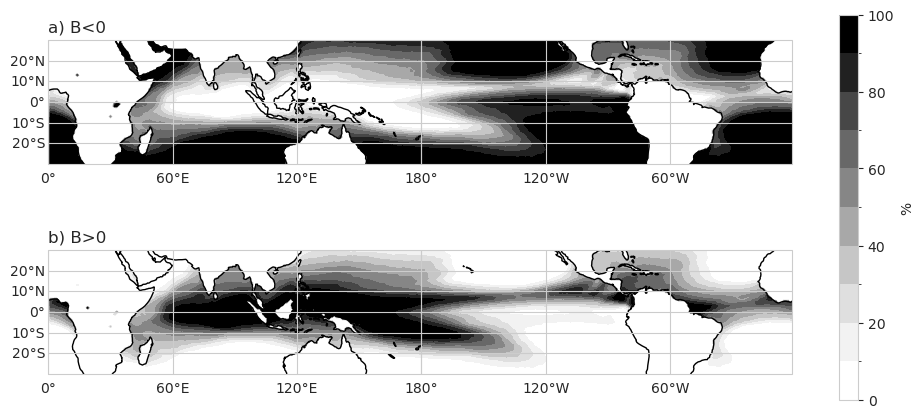

In [67]:

fig,axs = plt.subplots(nrows=2,subplot_kw={'projection':ccrs.PlateCarree(180)},figsize=[12,5])
Bxr = xr.DataArray.from_iris(Bmask)
levels=np.arange(0,110,10)
toplot = 100*(np.less(Bxr,0).mean('time'))
toplot.plot.contourf(cmap=plt.cm.Greys,label='%',ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,add_colorbar=False)
toplot = 100*(np.greater(Bxr,0).mean('time'))
cont = toplot.plot.contourf(cmap=plt.cm.Greys,label='%',ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,add_colorbar=False)
[ax.coastlines() for ax in axs]
gls=[ax.gridlines(draw_labels=True) for ax in axs]
[ax.set_title(t,loc='left') for ax,t in zip(axs,['a) B<0','b) B>0'])]
for gl in gls: 
    gl.top_labels=False
plt.colorbar(cont,ax=axs,label='%')
plt.savefig('./paper_figs/supp/FigS1.png',dpi=300,bbox_inches='tight',pad_inches=.1)
